<a href="https://colab.research.google.com/github/Makiato1999/ECG-Detector/blob/main/anomaly_detection_cnn_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import torch, os, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi

PyTorch: 2.9.0+cu126
CUDA available: True
Fri Dec  5 04:31:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   73C    P0             34W /   72W |     361MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----

In [94]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
import os
from types import SimpleNamespace
from sklearn.metrics import f1_score, accuracy_score, recall_score

matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Download dataset

In [95]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Path to dataset files: /kaggle/input/heartbeat


In [96]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


# Dataset: Segmented and Preprocessed ECG Signals for Heartbeat

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

Source: https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data?select=ptbdb_normal.csv

In [97]:
normal_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In [98]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


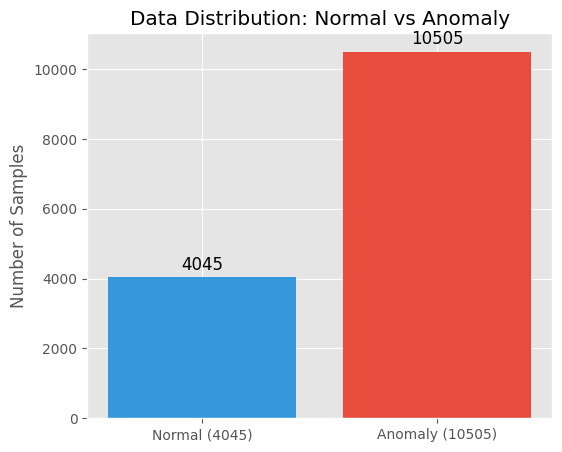

In [ ]:

counts = [len(normal_df), len(anomaly_df)]
labels = [f'Normal ({len(normal_df)})', f'Anomaly ({len(anomaly_df)})']
colors = ['#3498db', '#e74c3c']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, yval, ha='center', va='bottom', fontsize=12)

plt.title("Data Distribution: Normal vs Anomaly")
plt.ylabel("Number of Samples")
plt.show()

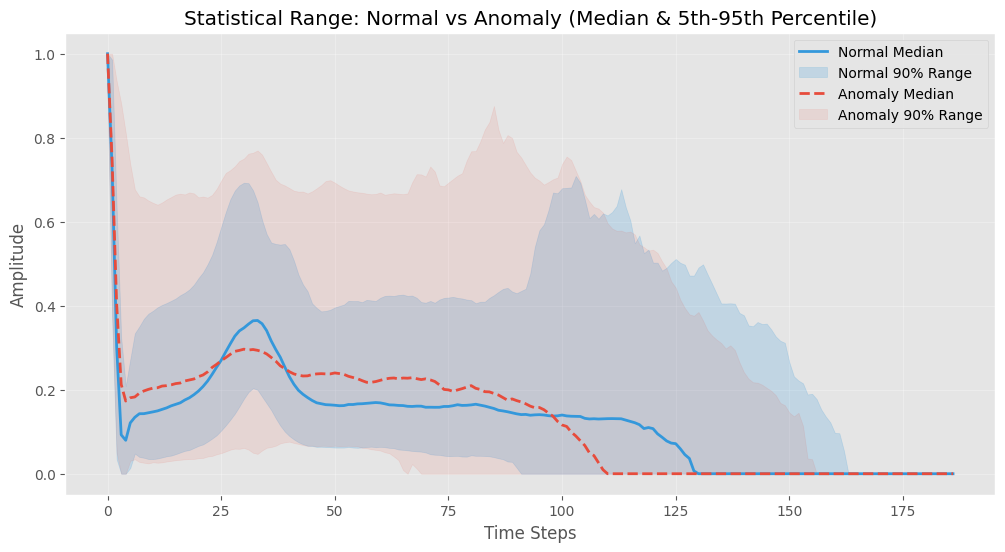

In [ ]:

def plot_percentile_range(normal, anomaly):
    plt.figure(figsize=(12, 6))

    def get_stats(df):
        median = np.nanpercentile(df, 50, axis=0)
        lower = np.nanpercentile(df, 5, axis=0)
        upper = np.nanpercentile(df, 95, axis=0)
        return median, lower, upper

    norm_mid, norm_low, norm_high = get_stats(normal)

    anom_mid, anom_low, anom_high = get_stats(anomaly)

    plt.plot(norm_mid, color='#3498db', linewidth=2, label='Normal Median')
    plt.fill_between(range(187), norm_low, norm_high, color='#3498db', alpha=0.2, label='Normal 90% Range')

    plt.plot(anom_mid, color='#e74c3c', linewidth=2, linestyle='--', label='Anomaly Median')
    plt.fill_between(range(187), anom_low, anom_high, color='#e74c3c', alpha=0.1, label='Anomaly 90% Range')

    plt.title("Statistical Range: Normal vs Anomaly (Median & 5th-95th Percentile)")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_percentile_range(normal_df, anomaly_df)

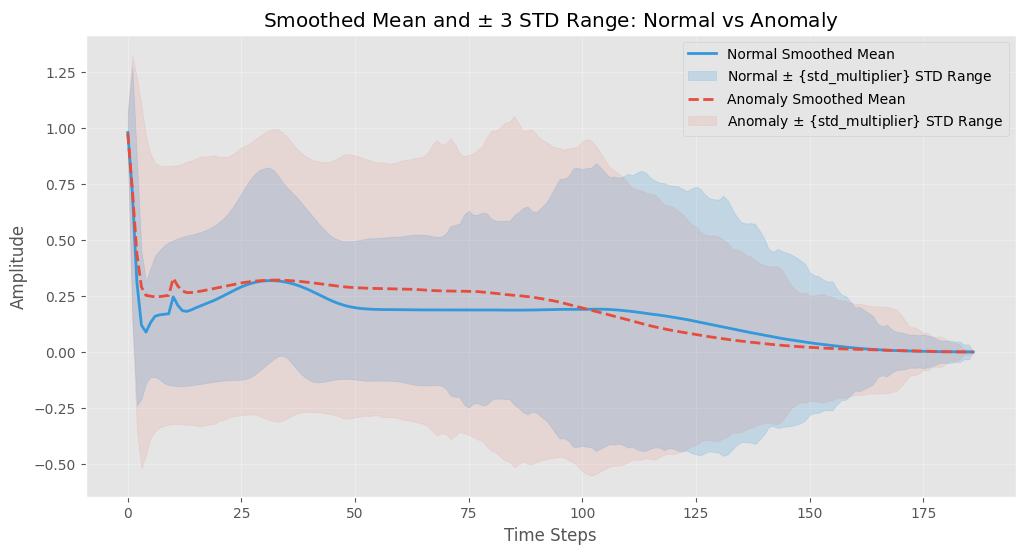

In [ ]:
time_steps = normal_df.shape[1] # 187

def calculate_smoothed_mean_stats_fixed(df, std_multiplier=3, window_size=20):

    mean_signal = df.mean(axis=0)
    std_signal = df.std(axis=0)

    smoothed_mean = mean_signal.rolling(window=window_size, center=True).mean()
    smoothed_mean = smoothed_mean.fillna(mean_signal)

    upper_bound = mean_signal + std_signal * std_multiplier
    lower_bound = mean_signal - std_signal * std_multiplier

    return smoothed_mean.values, lower_bound.values, upper_bound.values

def plot_smoothed_range(normal_df, anomaly_df, std_multiplier=3, window_size=20):
    plt.figure(figsize=(12, 6))

    time_steps_range = range(normal_df.shape[1])

    norm_mean, norm_low, norm_high = calculate_smoothed_mean_stats_fixed(
        normal_df, std_multiplier=std_multiplier, window_size=window_size
    )

    anom_mean, anom_low, anom_high = calculate_smoothed_mean_stats_fixed(
        anomaly_df, std_multiplier=std_multiplier, window_size=window_size
    )

    NORMAL_COLOR = '#3498db'

    plt.plot(time_steps_range, norm_mean, color=NORMAL_COLOR, linewidth=2, label='Normal Smoothed Mean')

    plt.fill_between(time_steps_range, norm_low, norm_high, color=NORMAL_COLOR, alpha=0.2, label=r'Normal $\pm$ {std_multiplier} STD Range')


    ANOMALY_COLOR = '#e74c3c'

    plt.plot(time_steps_range, anom_mean, color=ANOMALY_COLOR, linewidth=2, linestyle='--', label='Anomaly Smoothed Mean')

    plt.fill_between(time_steps_range, anom_low, anom_high, color=ANOMALY_COLOR, alpha=0.1, label=r'Anomaly $\pm$ {std_multiplier} STD Range')


    plt.title(r"Smoothed Mean and $\pm$ 3 STD Range: Normal vs Anomaly")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_smoothed_range(normal_df, anomaly_df)

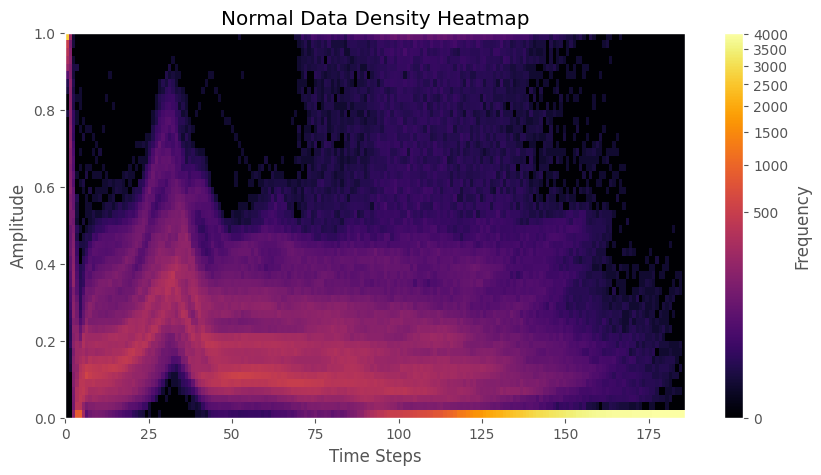

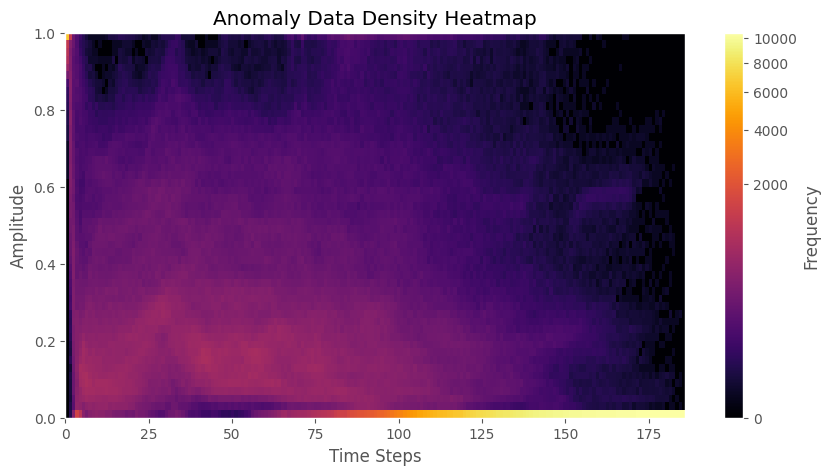

In [ ]:

import matplotlib.colors as mcolors

def plot_density_heatmap(df, title):
    x = np.tile(np.arange(187), len(df))
    y = df.values.flatten()

    plt.figure(figsize=(10, 5))
    plt.hist2d(x, y, bins=[187, 50], cmap='inferno', norm=mcolors.PowerNorm(0.3))
    plt.colorbar(label='Frequency')
    plt.title(f"{title} Density Heatmap")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.show()

plot_density_heatmap(normal_df, "Normal Data")

plot_density_heatmap(anomaly_df, "Anomaly Data")

Normal Data Range: [0.00, 1.00]
Anomaly Data Range: [0.00, 1.00]


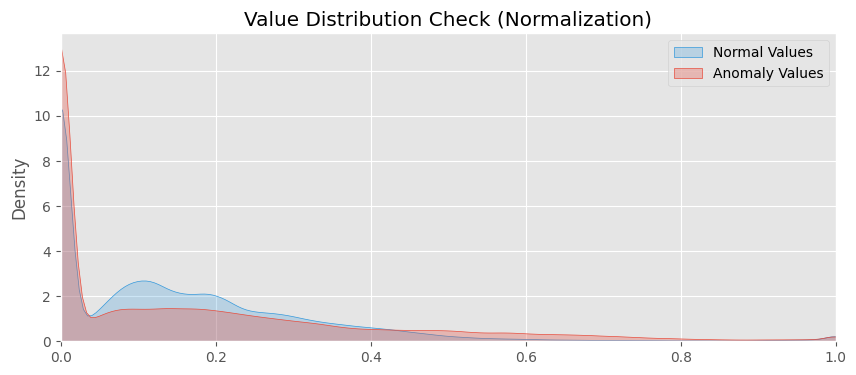

In [ ]:

print(f"Normal Data Range: [{normal_df.min().min():.2f}, {normal_df.max().max():.2f}]")
print(f"Anomaly Data Range: [{anomaly_df.min().min():.2f}, {anomaly_df.max().max():.2f}]")

plt.figure(figsize=(10, 4))
sns.kdeplot(normal_df.values.flatten(), color='#3498db', fill=True, label='Normal Values')
sns.kdeplot(anomaly_df.values.flatten(), color='#e74c3c', fill=True, label='Anomaly Values', alpha=0.3)
plt.title("Value Distribution Check (Normalization)")
plt.xlim(0, 1)
plt.legend()
plt.show()

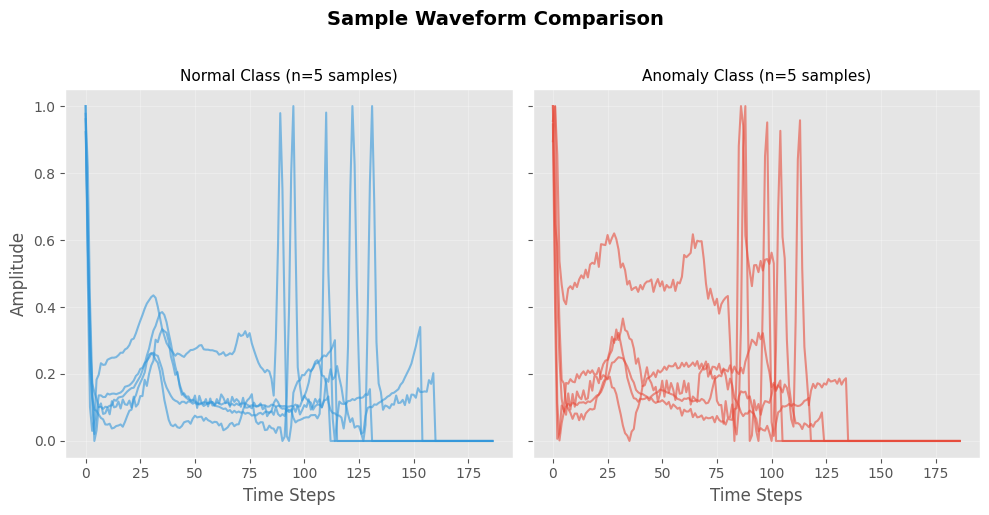

In [ ]:

def plot_sample_overlay(normal_df, anomaly_df, n_samples=5, title="Sample Waveform Comparison"):

    n_normal = min(n_samples, len(normal_df))
    n_anomaly = min(n_samples, len(anomaly_df))

    normal_indices = np.random.randint(0, len(normal_df), n_normal)
    anomaly_indices = np.random.randint(0, len(anomaly_df), n_anomaly)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    NORMAL_COLOR = '#3498db'

    for i, idx in enumerate(normal_indices):
        label = f"Sample {idx}" if i == 0 else None 
        ax[0].plot(normal_df.iloc[idx, :].values, color=NORMAL_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[0].set_title(f"Normal Class (n={n_normal} samples)", fontsize=11)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid(True, alpha=0.3)

    # ax[0].legend(loc='upper right', fontsize=9)

    ANOMALY_COLOR = '#e74c3c'

    for i, idx in enumerate(anomaly_indices):
        label = f"Sample {idx}" if i == 0 else None
        ax[1].plot(anomaly_df.iloc[idx, :].values, color=ANOMALY_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[1].set_title(f"Anomaly Class (n={n_anomaly} samples)", fontsize=11)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.3)
    # ax[1].legend(loc='upper right', fontsize=9)

    plt.suptitle(title, fontsize=14, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_sample_overlay(normal_df, anomaly_df, n_samples=5)

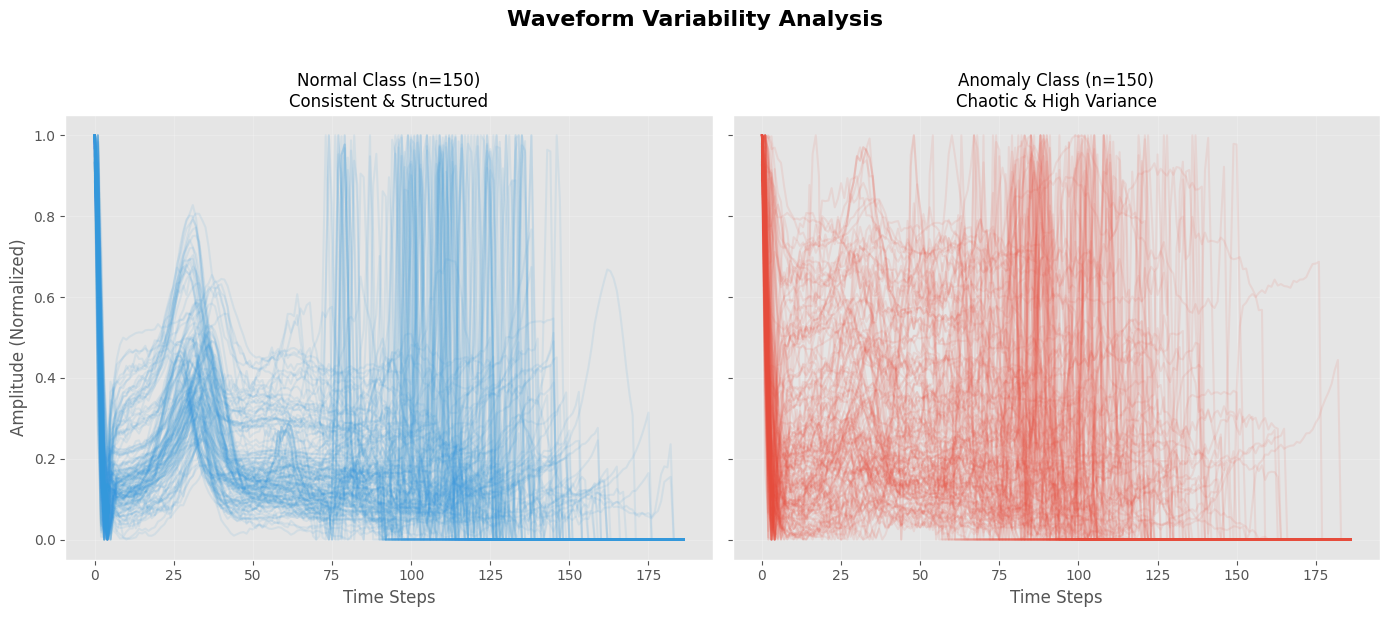

In [ ]:

def plot_waveform_overlay(normal, anomaly, n_samples=150, title="Waveform Variability Analysis"):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

    normal_indices = np.random.randint(0, len(normal), n_samples)

    for i in normal_indices:
        ax[0].plot(normal.iloc[i, :].values, color='#3498db', alpha=0.1, linewidth=1.5)

    ax[0].set_title(f"Normal Class (n={n_samples})\nConsistent & Structured", fontsize=12)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude (Normalized)")
    ax[0].grid(True, alpha=0.2) 

    anomaly_indices = np.random.randint(0, len(anomaly), n_samples)

    for i in anomaly_indices:
        ax[1].plot(anomaly.iloc[i, :].values, color='#e74c3c', alpha=0.1, linewidth=1.5)

    ax[1].set_title(f"Anomaly Class (n={n_samples})\nChaotic & High Variance", fontsize=12)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.2)

    plt.suptitle(title, fontsize=16, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_waveform_overlay(normal_df, anomaly_df, n_samples=150)

# Configuration

In [106]:
from dataclasses import dataclass

@dataclass
class Config:
    epochs: int = 50
    learning_rate: float = 0.001
    batch_size: int = 64
    use_augmentation: bool = False
    input_dim: int = 187
    latent_dim: int = 32
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_path: str = './checkpoints'
    model_name: str = 'best_autoencoder.pth'

config = Config(
    epochs=50,
    learning_rate=0.001,
    batch_size=64,
    use_augmentation=True,
    input_dim = 187,
    latent_dim = 32,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Normal-only Scaler

In [107]:
normal = normal_df.to_numpy().astype(np.float64)
anomaly = anomaly_df.to_numpy().astype(np.float64)

In [108]:
from types import SimpleNamespace

def split_normal_data(normal, anomaly, seed=45):
    X_train, X_temp = train_test_split(
        normal, test_size=0.30, random_state=seed, shuffle=True
    )

    X_validate, X_test = train_test_split(
        X_temp, test_size=0.50, random_state=seed, shuffle=True
    )

    return SimpleNamespace(
        train=X_train,
        val=X_validate,
        test=X_test,
        anomaly=anomaly
    )

data_split = split_normal_data(normal, anomaly)

X_train = data_split.train
X_validate = data_split.val
X_test = data_split.test
anomaly = data_split.anomaly
print("Train:", X_train.shape)
print("Valid:", X_validate.shape)
print("Test :", X_test.shape)

Train: (2831, 187)
Valid: (607, 187)
Test : (607, 187)


In [ ]:
# Normal-only Scaler
from sklearn.preprocessing import StandardScaler
from types import SimpleNamespace

def scaler_data(X_train, X_validate, X_test, anomaly):
  scaler = StandardScaler()
  scaler.fit(X_train)   

  X_train_scaled    = scaler.transform(X_train)
  X_validate_scaled = scaler.transform(X_validate)
  X_test_scaled     = scaler.transform(X_test)
  anomaly_scaled    = scaler.transform(anomaly)

  print("Train:", X_train_scaled.shape)
  print("Valid:", X_validate_scaled.shape)
  print("Test :", X_test_scaled.shape)

  return SimpleNamespace(
    X_train_scaled=X_train_scaled,
    X_validate_scaled=X_validate_scaled,
    X_test_scaled=X_test_scaled,
    anomaly_scaled=anomaly_scaled,
    scaler=scaler
  )

In [ ]:
class AnomalyDetectionDataset(Dataset):
    """
    PyTorch Dataset for Autoencoder Anomaly Detection.
    X = Y = input itself.
    """
    def __init__(self, np_array):
        self.data = torch.from_numpy(np_array).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x, x  

In [111]:
def get_datasets(data_split, use_scaled = False):
  if use_scaled:
    scaled = scaler_data(
        data_split.train,
        data_split.val,
        data_split.test,
        data_split.anomaly
    )
    X_train = scaled.X_train_scaled
    X_val   = scaled.X_validate_scaled
    X_test  = scaled.X_test_scaled
    anomaly = scaled.anomaly_scaled
  else:
    X_train = data_split.train
    X_val   = data_split.val
    X_test  = data_split.test
    anomaly = data_split.anomaly

  train_ds = AnomalyDetectionDataset(X_train)
  val_ds   = AnomalyDetectionDataset(X_val)
  test_ds  = AnomalyDetectionDataset(X_test)
  anom_ds  = AnomalyDetectionDataset(anomaly)

  return SimpleNamespace(
      train=train_ds,
      val=val_ds,
      test=test_ds,
      anomaly=anom_ds
  )

In [112]:
# 6. DataLoaders
BATCH_SIZE = config.batch_size

# datasets = get_datasets(data_split, use_scaled=False)
datasets = get_datasets(data_split, use_scaled=True)


train_dataset = datasets.train
validate_dataset = datasets.val
test_dataset = datasets.test
anomaly_dataset = datasets.anomaly

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Valid batches:", len(validate_loader))
print("Test batches :", len(test_loader))
print("Anomaly batches:", len(anomaly_loader))

Train: (2831, 187)
Valid: (607, 187)
Test : (607, 187)
Train batches: 45
Valid batches: 10
Test batches : 10
Anomaly batches: 165


# Normal-only Data Augmentation

In [ ]:
import random

def augment_ecg(batch, jitter_std=0.01, scale_std=0.05, max_shift=2):
    """
    batch: (B, 188)
    """
    B, T = batch.shape

    jitter = torch.randn_like(batch) * jitter_std
    batch = batch + jitter

    # scale = 1.0 + torch.randn(B, 1, device=batch.device) * scale_std
    scale = 1.0 + torch.randn_like(batch[:, :1]) * scale_std
    batch = batch * scale

    shift = random.randint(-max_shift, max_shift)
    batch = torch.roll(batch, shifts=shift, dims=1)

    return batch


# CNN Autoencoder Model

In [ ]:
torch.manual_seed(1024)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()

        # --- 1. Encoder ---
        # Conv1d Input: (Batch, Channel=1, Length=input_dim)
        self.encoder = nn.Sequential(
            # Layer 1: Conv1D(128, 3) + BN + MaxPool
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            # Layer 2: Conv1D(128, 3) + BN + MaxPool
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            # Layer 3: Conv1D(latent_dim, 3) + BN + MaxPool
            nn.Conv1d(in_channels=128, out_channels=latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # --- 2. Decoder Conv part (does not change the length, only the channel) ---
        self.decoder_conv = nn.Sequential(
            # Layer 1: Transpose(latent_dim -> latent_dim)
            nn.ConvTranspose1d(in_channels=latent_dim, out_channels=latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),

            # Layer 2: Transpose(latent_dim -> 128)
            nn.ConvTranspose1d(in_channels=latent_dim, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            # Layer 3: Transpose(128 -> 128)
            nn.ConvTranspose1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        # --- 3. Automatically calculate the Flatten size after "encoder + decoder_conv" ---
        self._flatten_size = self._get_flatten_size(input_dim, latent_dim)

        self.decoder_dense = nn.Linear(self._flatten_size, input_dim)

        self.final_activation = nn.Identity()

    def _get_flatten_size(self, input_dim, latent_dim):

        dummy_input = torch.zeros(1, 1, input_dim)   # shape: [1, 1, 187]
        with torch.no_grad():
            encoded = self.encoder(dummy_input)      # [1, latent_dim, L_enc]
            decoded = self.decoder_conv(encoded)     # [1, 128, L_dec]
        return decoded.view(1, -1).size(1)

    def forward(self, x):
        # x shape: [Batch, 187]

        # 1. Reshape for Conv1d: [Batch, 187] -> [Batch, 1, 187]
        x = x.unsqueeze(1)

        # 2. Encoder: [B, 1, 187] -> [B, latent_dim, L_enc]
        encoded = self.encoder(x)

        # 3. Decoder Conv Block: [B, latent_dim, L_enc] -> [B, 128, L_dec]
        decoded = self.decoder_conv(encoded)

        # 4. Flatten: [B, 128, L_dec] -> [B, flatten_size]
        decoded = decoded.view(decoded.size(0), -1)

        # 5. Dense to input_dim
        reconstructed = self.decoder_dense(decoded)

        reconstructed = self.final_activation(reconstructed)

        return reconstructed

In [ ]:
def train_model(model, train_loader, val_loader, config: Config):
    device = torch.device(config.device)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.L1Loss()

    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')

    print(f"Start training on {config.device} for {config.epochs} epochs...")

    for epoch in range(config.epochs):

        # --- Training Phase ---
        model.train()
        train_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(config.device)

            if config.use_augmentation:
                data_aug = augment_ecg(data).to(config.device)
            else:
                data_aug = data

            optimizer.zero_grad()
            outputs = model(data_aug)
            loss = criterion(outputs, data) 
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch, _ in val_loader:
                batch = batch.to(config.device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{config.epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # --- Save Best Model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            if not os.path.exists(config.save_path):
                os.makedirs(config.save_path)

            save_full_path = os.path.join(config.save_path, config.model_name)

            torch.save(model.state_dict(), save_full_path)
            print(f"  >>> Best model saved to {save_full_path}!")

    print("Training Complete.")
    return history

🚀 Training Started...
Start training on cuda for 50 epochs...
Epoch [1/50] Train Loss: 0.359048 | Val Loss: 0.276882
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [2/50] Train Loss: 0.262723 | Val Loss: 0.222934
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [3/50] Train Loss: 0.227273 | Val Loss: 0.201224
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [4/50] Train Loss: 0.217062 | Val Loss: 0.230199
Epoch [5/50] Train Loss: 0.202640 | Val Loss: 0.174925
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [6/50] Train Loss: 0.192831 | Val Loss: 0.192128
Epoch [7/50] Train Loss: 0.191554 | Val Loss: 0.168694
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [8/50] Train Loss: 0.184616 | Val Loss: 0.168397
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [9/50] Train Loss: 0.180618 | Val Loss: 0.155602
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [10

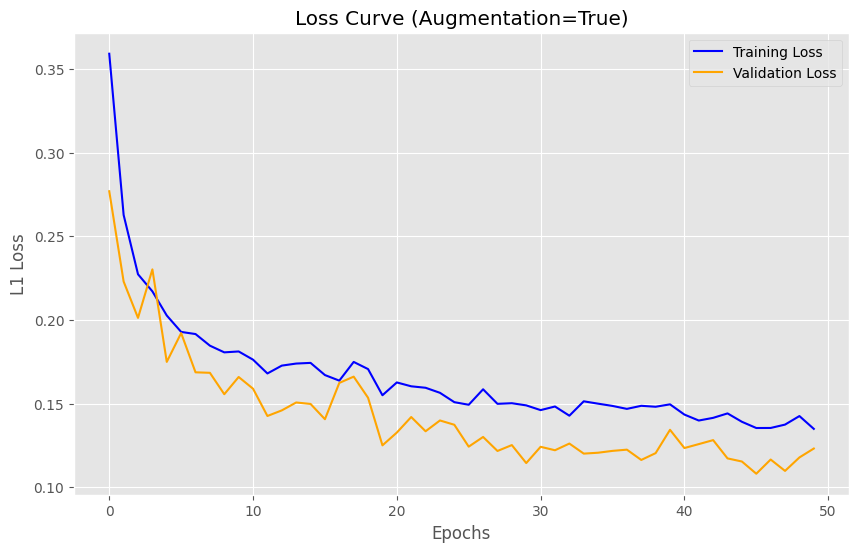

In [122]:
model = AutoEncoder(input_dim=config.input_dim, latent_dim=config.latent_dim)
print("🚀 Training Started...")
history = train_model(model, train_loader, validate_loader, config)

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss Curve (Augmentation={config.use_augmentation})')
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def compute_raw_mae(model, loader, scaler, device="cuda"):
    model.eval()
    mae_list = []

    with torch.no_grad():
        for batch, _ in loader:
            batch = batch.to(device)

            recon = model(batch)           # (B,187)

            orig = batch.cpu().numpy()     # scaled space
            recon = recon.cpu().numpy()

            # ---- inverse transform back raw space ----
            orig_raw = scaler.inverse_transform(orig)
            recon_raw = scaler.inverse_transform(recon)

            # ---- MAE in raw space ----
            mae = np.mean(np.abs(orig_raw - recon_raw), axis=1) 
            mae_list.append(mae)

    mae_list = np.concatenate(mae_list)
    return mae_list

In [ ]:
# Calculate the Raw-Space MAE for the Normal / Test / Anomaly datasets.
scaler = StandardScaler()
scaler.fit(X_train)

raw_mae_train = compute_raw_mae(model, train_loader, scaler)
raw_mae_validate = compute_raw_mae(model, validate_loader, scaler)
raw_mae_test = compute_raw_mae(model, test_loader, scaler)
raw_mae_anomaly = compute_raw_mae(model, anomaly_loader, scaler)

print("Training raw-space MAE: ", raw_mae_train.mean())
print("Testing raw-space MAE :", raw_mae_test.mean())
print("Anomaly raw-space MAE:", raw_mae_anomaly.mean())

Training raw-space MAE:  0.014418184
Testing raw-space MAE : 0.015270892
Anomaly raw-space MAE: 0.029951043


# Calculate Accuracy / Precision / Recall / F1

In [ ]:
def find_threshold_statistical(loss):

    mean_loss = loss.mean()
    std_loss = loss.std()

    threshold = mean_loss + 1.0 * std_loss

    print(f"Statistical threshold (Mean + 1*STD): {threshold:.5f}")
    return threshold

threshold = find_threshold_statistical(raw_mae_train)

统计学阈值 (Mean + 1*STD): 0.01845


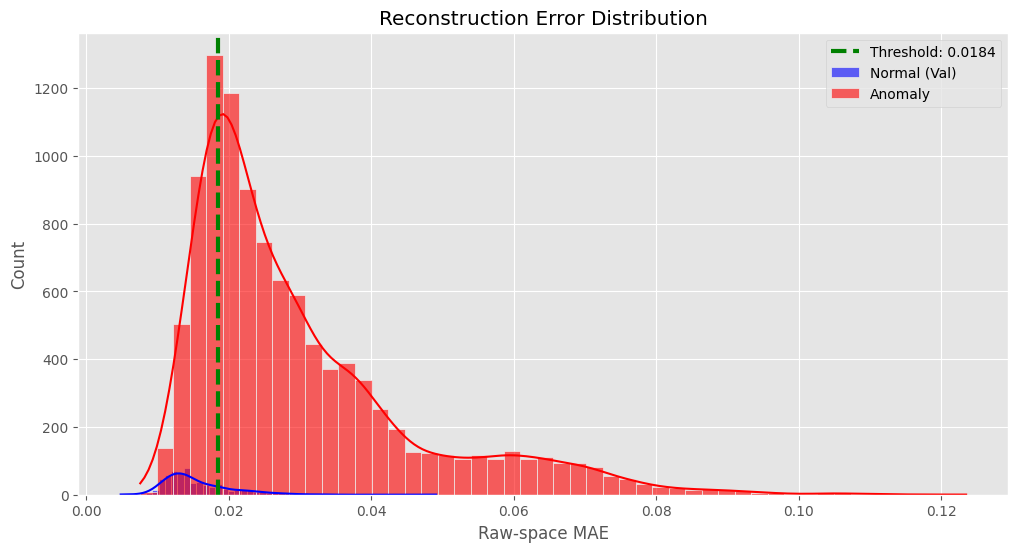

In [ ]:
plt.figure(figsize=(12, 6))

# Normal
sns.histplot(raw_mae_validate, bins=50, kde=True, color='blue', label='Normal (Val)', alpha=0.6)

# Anomaly
sns.histplot(raw_mae_anomaly, bins=50, kde=True, color='red', label='Anomaly', alpha=0.6)

plt.axvline(threshold, color='green', linestyle='--', linewidth=3, label=f'Threshold: {threshold:.4f}')

plt.title("Reconstruction Error Distribution")
plt.xlabel("Raw-space MAE")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n=== Final test results ===")

# ---- Normal Test Set (All results are normal) ----
# GT: 0; Prediction: MAE > threshold → 1 (anomaly)
y_test_true = np.zeros_like(raw_mae_test)  # [0,0,0,...]
y_test_pred = (raw_mae_test > threshold).astype(int)

# ---- Anomaly Collection (All Anomalies) ----
y_anom_true = np.ones_like(raw_mae_anomaly)  # [1,1,1,...]
y_anom_pred = (raw_mae_anomaly > threshold).astype(int)

# ---- Merging, used for overall evaluation ----
y_true = np.concatenate([y_test_true, y_anom_true])
y_pred = np.concatenate([y_test_pred, y_anom_pred])

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Overall Accuracy:  {acc*100:.2f}%")
print(f"Precision (Anom):  {prec*100:.2f}%")
print(f"Recall (Anom):     {rec*100:.2f}%")
print(f"F1 Score:          {f1*100:.2f}%")



=== 最终测试结果 ===
Overall Accuracy:  76.76%
Precision (Anom):  98.63%
Recall (Anom):     76.49%
F1 Score:          86.16%


In [ ]:
# Normal Test Accuracy: In the normal test set, how many values ​​are judged as 0 (normal)
normal_acc = np.mean(y_test_pred == 0)

# Anomaly Recall: How many instances in the anomaly set are judged as 1 (abnormal)
anomaly_recall = np.mean(y_anom_pred == 1)

print(f"\n[Summary]")
print(f"Normal Test Accuracy: {normal_acc:.2%}")
print(f"Anomaly Recall:       {anomaly_recall:.2%}")



[Summary]
Normal Test Accuracy: 81.55%
Anomaly Recall:       76.49%


Confusion Matrix:
[[ 495  112]
 [2470 8035]]


<Figure size 500x500 with 0 Axes>

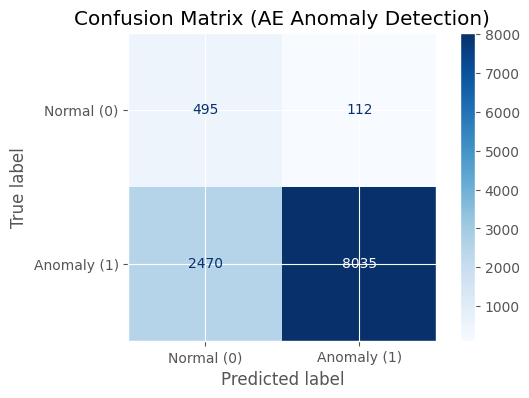

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Anomaly (1)'])
plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (AE Anomaly Detection)")
plt.show()


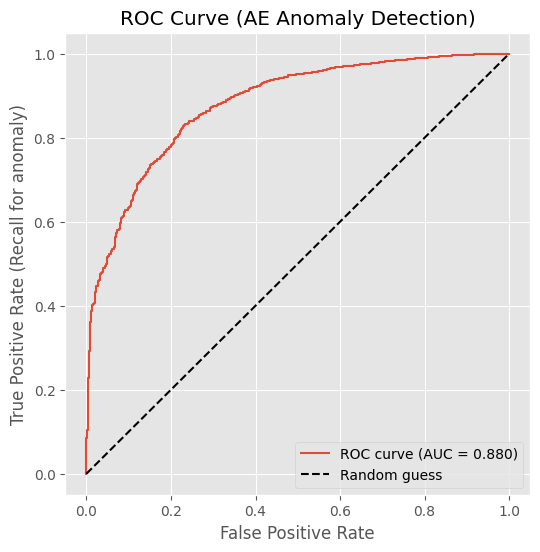

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


y_scores = np.concatenate([raw_mae_test, raw_mae_anomaly])  
# y_true 

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall for anomaly)")
plt.title("ROC Curve (AE Anomaly Detection)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


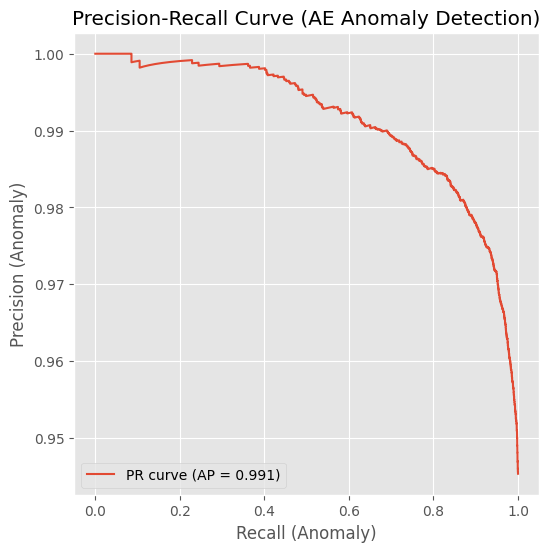

In [151]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall (Anomaly)")
plt.ylabel("Precision (Anomaly)")
plt.title("Precision-Recall Curve (AE Anomaly Detection)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
